# ASHRAE - Great Energy Predictor III

## Import libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# sklearn tools and models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Import Data

#### train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

#### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

- row_id - Row id for your submission file
- building_id - Building id code
- meter - The meter id code
- timestamp - Timestamps for the test data period

#### building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

#### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in oktas
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second

In [12]:
# train.csv
train_df = pd.read_csv("./data/train.csv")
# Copy
train = train_df

# test.csv
test_df = pd.read_csv("./data/test.csv")
# Copy
test = test_df

# building_meta.csv
build_meta_df = pd.read_csv("./data/building_metadata.csv")
# Copy
build_meta = build_meta_df

# weather_train.csv
weather_train_df = pd.read_csv("./data/weather_train.csv")
# Copy
weather_train = weather_train_df

# weather_test.csv
weather_test_df = pd.read_csv("./data/weather_test.csv")
# Copy
weather_test = weather_test_df

## Auxiliar Functions

In [28]:
# Function to print main info about the dataset
def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
    print(df.isnull().sum())
    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
    print(df.head())
    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
    print(df.tail())
    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe())
    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))

## Exploratory Data Analysis

#### Train Dataset

In [29]:
ds_info(train)

SIZE
80864400

SHAPE
(20216100, 4)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None

NULL VALUES
building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

HEAD
   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

TAIL
          building_id  meter            timestamp  meter_reading
20216095         1444      0  2016-12-31 23:00:00          8.750
20216096        

#### Building Meta

In [30]:
ds_info(build_meta)

SIZE
8694

SHAPE
(1449, 6)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB
None

NULL VALUES
site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

HEAD
   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        

#### Weather Train

In [36]:
ds_info(weather_train)

SIZE
1257957

SHAPE
(139773, 9)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None

NULL VALUES
site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         626

#### Weather Test

In [37]:
ds_info(weather_test)

SIZE
2495187

SHAPE
(277243, 9)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int64  
 1   timestamp           277243 non-null  object 
 2   air_temperature     277139 non-null  float64
 3   cloud_coverage      136795 non-null  float64
 4   dew_temperature     276916 non-null  float64
 5   precip_depth_1_hr   181655 non-null  float64
 6   sea_level_pressure  255978 non-null  float64
 7   wind_direction      264873 non-null  float64
 8   wind_speed          276783 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB
None

NULL VALUES
site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction    

### Missing data

<AxesSubplot:>

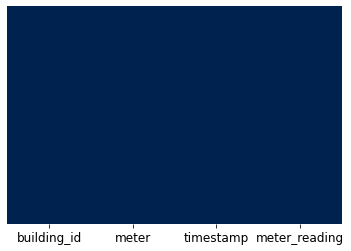

In [39]:
# Train
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='cividis')

<AxesSubplot:>

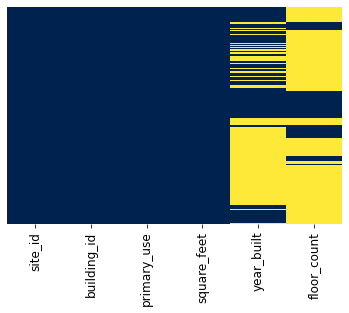

In [40]:
# build_meta
sns.heatmap(build_meta.isnull(),yticklabels=False,cbar=False,cmap='cividis')

<AxesSubplot:>

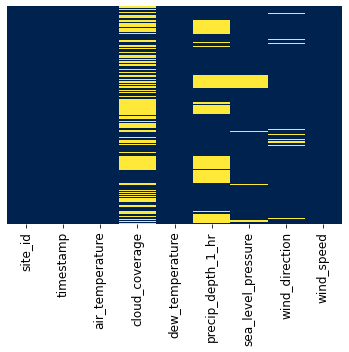

In [41]:
# weather_train
sns.heatmap(weather_train.isnull(),yticklabels=False,cbar=False,cmap='cividis')

<AxesSubplot:>

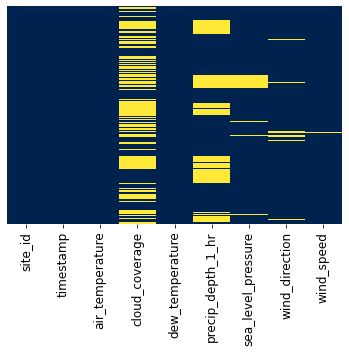

In [42]:
# weather_train
sns.heatmap(weather_test.isnull(),yticklabels=False,cbar=False,cmap='cividis')

#### Summary
- train: no missing data
- build_meta: most year_built and floor_count columns have missing data, analyse if worth drop or fulfill these columns
- weather_train
    - cloud_coverage: most rows are missing data, but this could means just a sunny day. It worth investigate again other features if is just missing data or a sunny day
    - precip_depth_1_hr: the missing data could mean missing data or drought period 
    - sea_level: few missing data that probably can be fulfilled using avarage
    - wind_direction: few rows with missing data, can be fulfilled

### Train dataset

In [47]:
#sns.displot(train['meter_reading'])

### Build_meta dataset - Categorical analysis
#### Primary_use 
Indicator of the primary category of activities for the building based on EnergyStar property type definitions

<AxesSubplot:xlabel='primary_use', ylabel='count'>

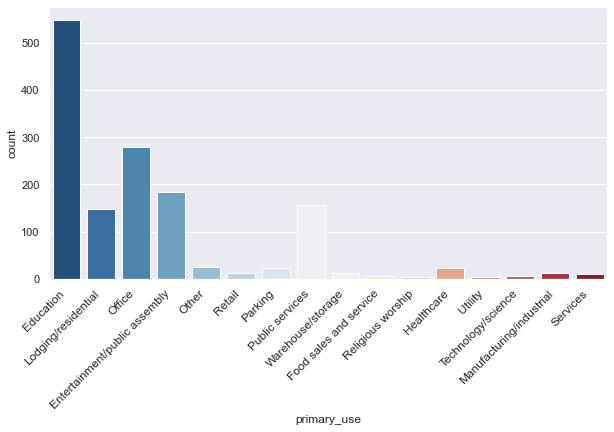

In [71]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'  
)
sns.countplot(x='primary_use',data=build_meta,palette='RdBu_r')

<AxesSubplot:title={'center':'Primary Use'}>

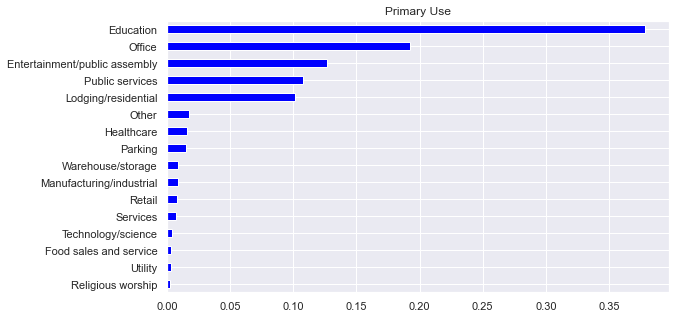

In [73]:
build_meta['primary_use'].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
        figsize=(9,5),
        title='Primary Use',
        color='blue')

Summary:
- Majority of buldings have Education as primary use (38%)
- Office building occupy almost 20%, together Education and Office have almost 60% of the sample
- Roughly 90% are occupied by Education, Office, Lodging/Residential, Entertainment/public Assembly and Public services 

In [ ]:
#sns.displot(train['meter_reading'])

### Build_meta dataset - Quantitative analysis
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

#### Square feet

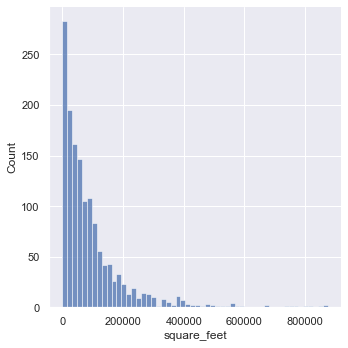

In [74]:
sns.displot(build_meta['square_feet'])

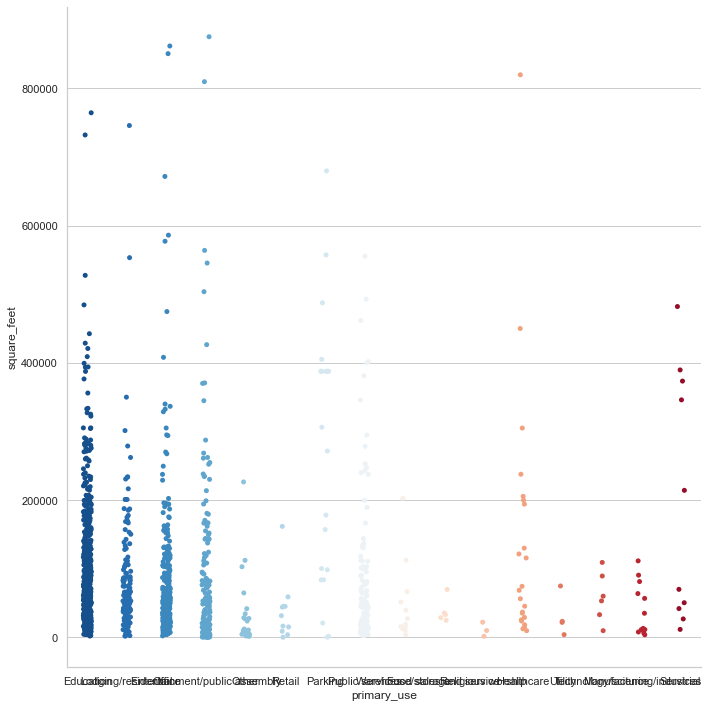

In [114]:
#tips = sns.load_dataset("tips")
#sns.set_style('whitegrid')
#sns.set(rc={'figure.figsize':(14,14)})
#plt.xticks(
#    rotation=45, 
#    horizontalalignment='right',
#    fontweight='light',
#    fontsize='medium'  
#)
sns.catplot(data=build_meta, x="primary_use", y="square_feet",height=10, aspect=10/10, palette='RdBu_r')

In [ ]:
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64